In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



Num_Points = 2


In [2]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[10,8])

#Reg_Data.df().head()

In [3]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.34887728016664343


MLPRegressor(random_state=RandomState(MT19937) at 0x179FEC69840)

In [4]:
Reg_Data.Random_Forest()

0.27676047438471363


RandomForestRegressor(random_state=RandomState(MT19937) at 0x179FEC69840)

In [5]:
Reg_Data.GP()

-0.0431060736860307


GaussianProcessRegressor()

In [6]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [7]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [8]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 19.1079506    7.71909458  14.44919276  11.31442483   6.91877598
  19.36472351 -18.88844399  11.17022823]
Std 0:  [1.98082984 5.43905655 3.51941866 3.79141587 3.92856298 2.05316443
 1.5548957  3.4081115 ]


In [9]:
# Generate explantion data for Random Forest

Reg_Stats = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points == 0: Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model())


INSTANCE:  0
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[27.30077156] [2.73007715e+01 1.00000004e-05] [27.30077155]
INSTANCE:  1
Acq_Data_nD
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[18.96355363] [1.89635536e+01 1.00000004e-05] [18.96355363]


In [10]:
import matplotlib.pyplot as plt


In [11]:
print(f_predict)
print(e_predict)


[18.96355363]
[1.89635536e+01 1.00000004e-05]


In [12]:
Reg_Stats.Feature_Counts(max_features=6, scaled=True, threshold=0.05)


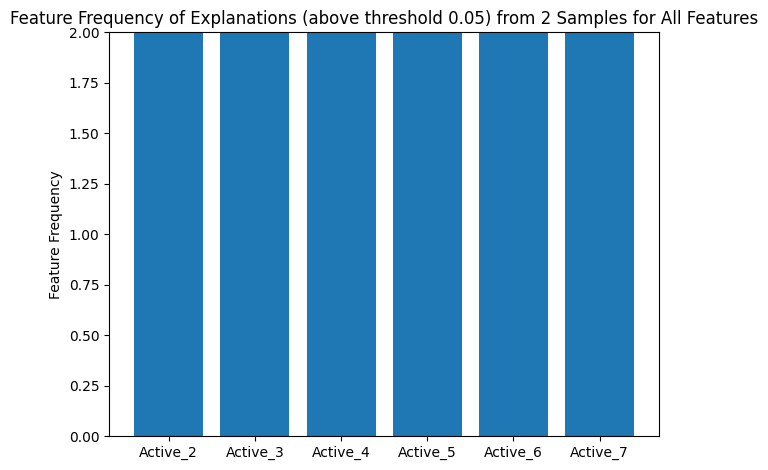

In [13]:
Reg_Stats.Frequency_Plot()


In [14]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           23.63520791789941  :  47.11792688147816  :  30.499457831872398
y - exp(x):          23.635207914202404  :  47.11792680032476  :  30.49945782226408
BB(x) - exp(x):      5.911308775807811e-09  :  1.3667874963593745e-17  :  9.608317697029634e-09
Average exp(x) var:  1.0000000413701846e-05


In [15]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


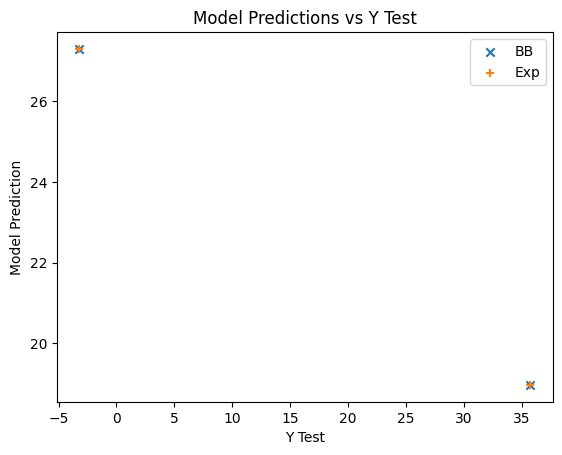

In [16]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (2, 6)


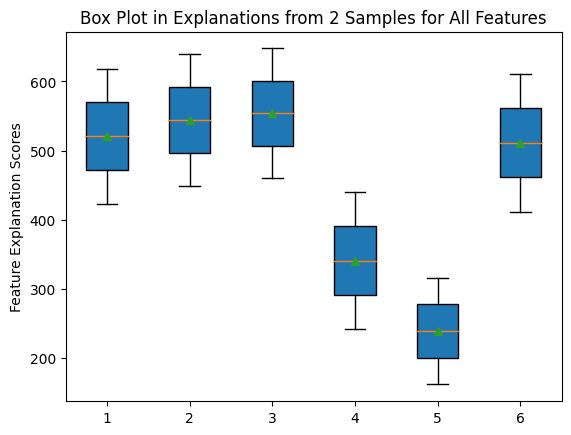

1 -      Active_2
2 -      Active_3
3 -      Active_4
4 -      Active_5
5 -      Active_6
6 -      Active_7


In [17]:
Reg_Stats.Box_Plot()


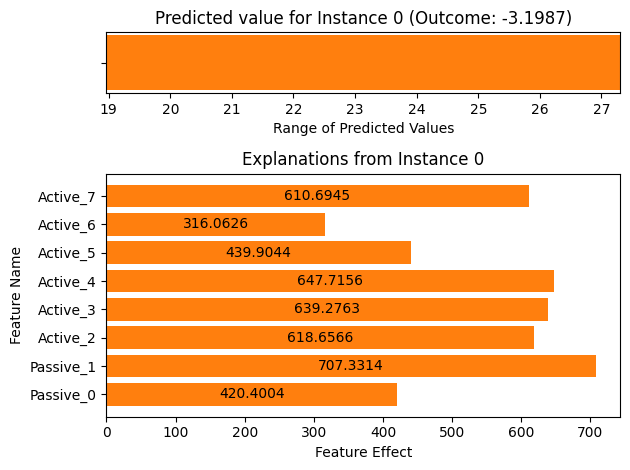

In [18]:
Reg_Stats.View_Explanation(instance = 0)

In [19]:
scores = URM_Exp.permutation_importance()
    


In [20]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[8.88196338 8.748112   8.80294114 8.78648428 8.77834746 8.87916175
 8.89634864 8.80966182]


In [21]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[65.8467707  83.95235346 71.03682031 72.34777205 73.06182255 66.01627567
 64.98168816 70.53860918]


In [22]:
scores_x = URM_Exp.del_1_rel()

print(scores_x)

[0.99929645 1.00485353 0.99929645 0.99930884 0.99935455 0.99929645
 0.99929645 0.99929729]


In [23]:
scores_x2 = URM_Exp.del_2_rel()

print(scores_x2)

[0.66666667 0.66666667 0.         0.         0.         6.
 0.66666667 0.        ]


In [24]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.57960680e-02  9.98950810e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.93087035e-05 -3.47876566e-06  9.99999995e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [25]:
acq_data.Create_BB_plot()

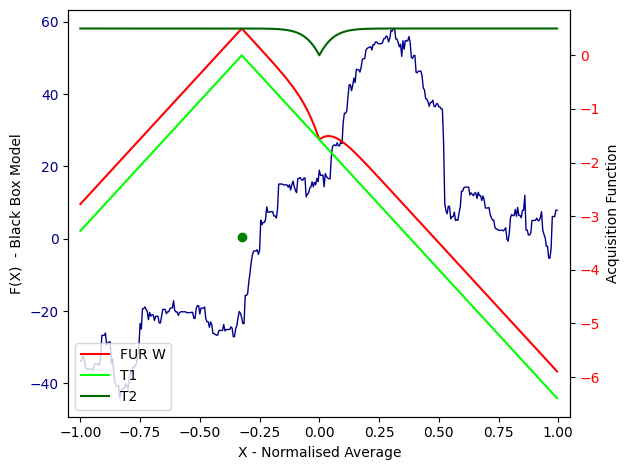

In [26]:
acq_data.plot_point(0)

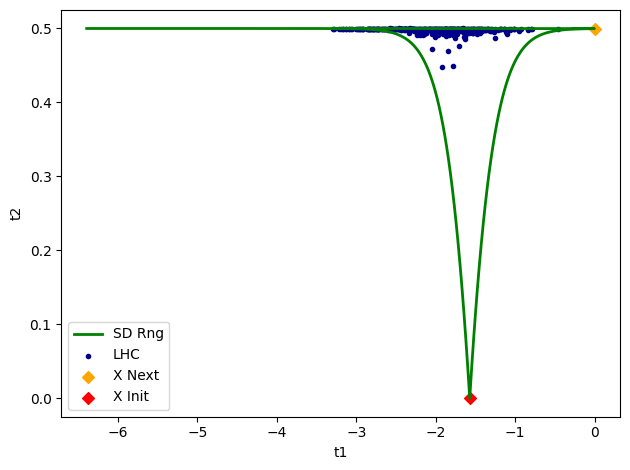

In [27]:
acq_data.plot_t1_t2(0)

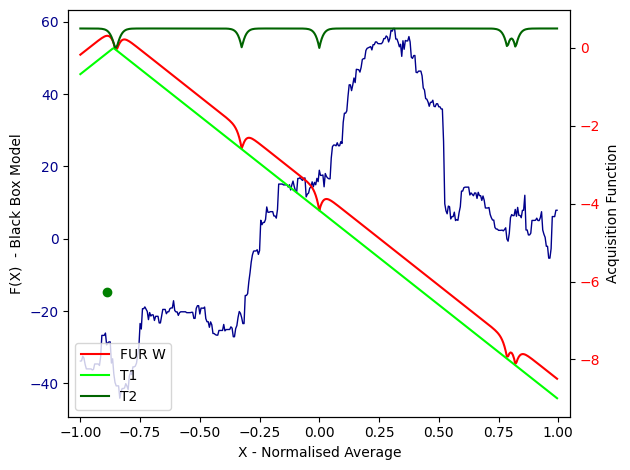

In [28]:
acq_data.plot_point(5)

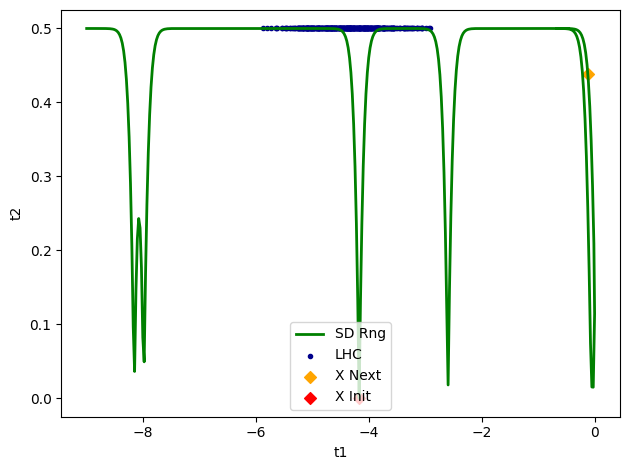

In [29]:
acq_data.plot_t1_t2(5)

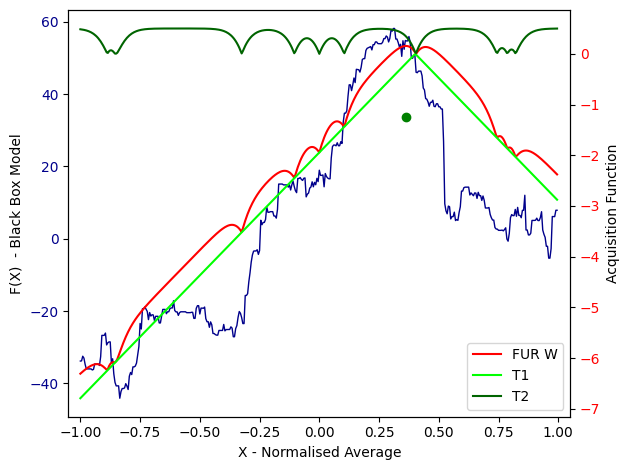

In [30]:
acq_data.plot_point(10)

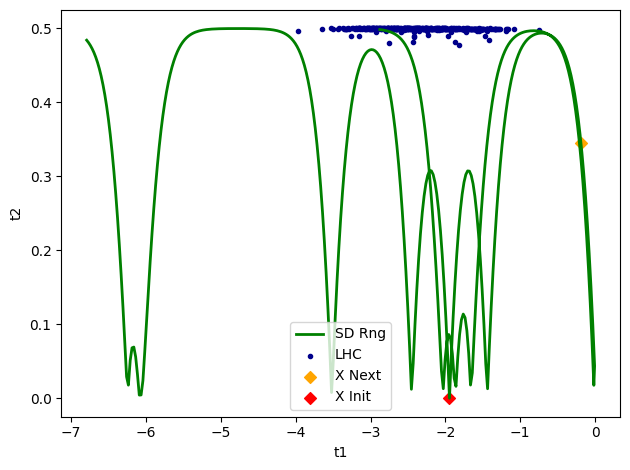

In [31]:
acq_data.plot_t1_t2(10)

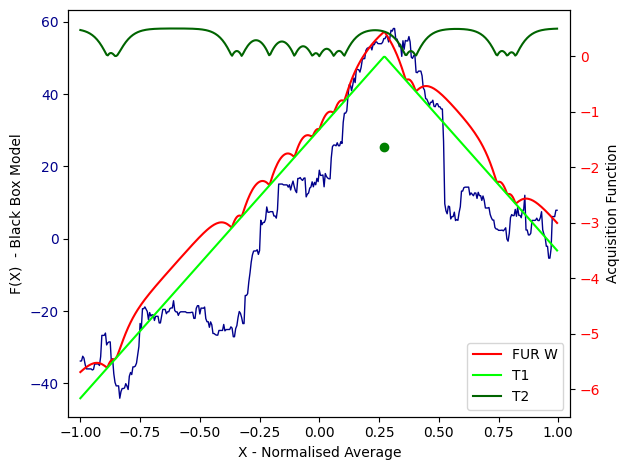

In [32]:
acq_data.plot_point(15)

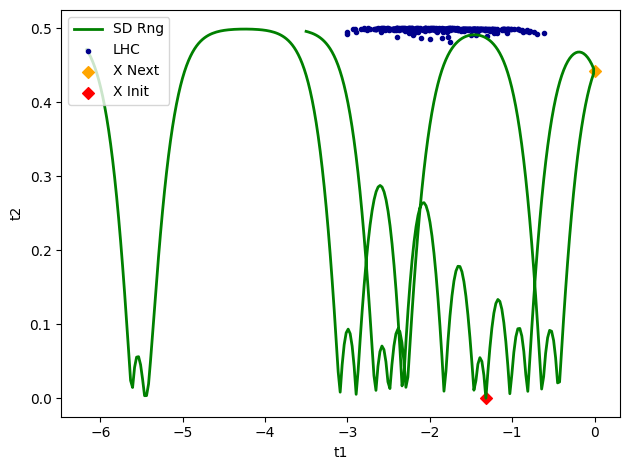

In [33]:
acq_data.plot_t1_t2(15)

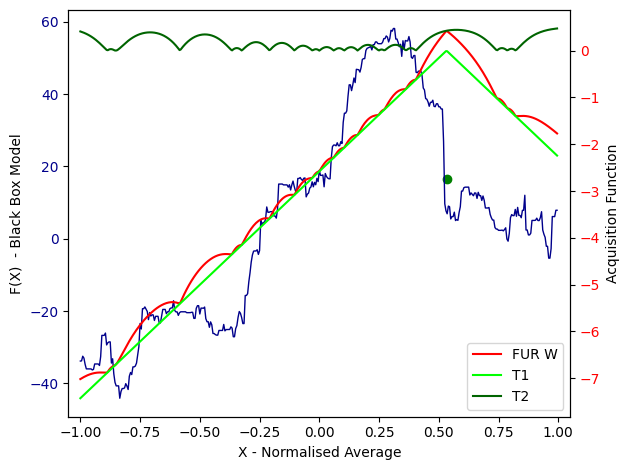

In [34]:
acq_data.plot_point(19)

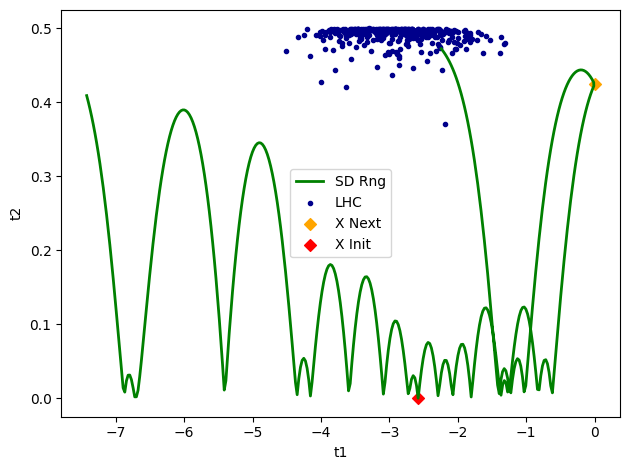

In [35]:
acq_data.plot_t1_t2(19)

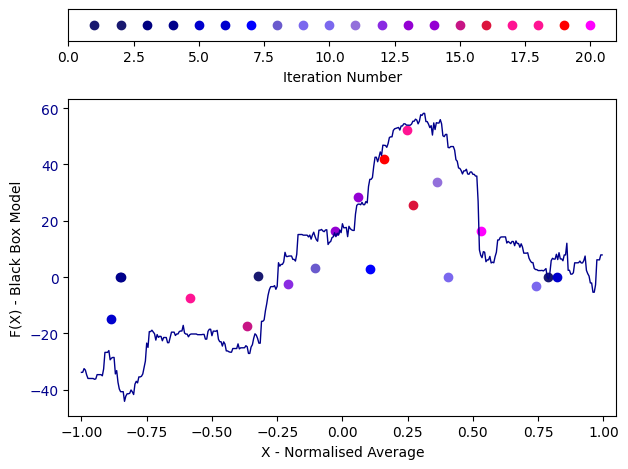

In [36]:
acq_data.plot_all()